let us go with basic mining valors: jsw, lwb, kghm, cle
NOTE: inflation and dividends are not taken into account

## download transform load sample ticker for analysis

In [1]:
from transform import download_transform_load
from const import *

In [2]:
tickers = ["jsw", "lwb", "kgh", "cla"]
for ticker in tickers:
    download_transform_load(ticker, DataDownloadSource.STOOQ_PL)

INFO:root:Stock returned jsw
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned lwb
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned kgh
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned cla
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database


## SQL data exploration

In [4]:
%load_ext sql
%sql sqlite:///SQLite.db

In [5]:
%%sql
SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///SQLite.db
Done.


KeyError: 'DEFAULT'

NOTE sql magic does not work properly, let us use sqlite3 cursor as mock of sql magic

In [2]:
import pandas as pd
import sqlite3
from pprint import pprint
def mock_sql_magic(query:str, return_data:bool=False):
    try:
        conn = sqlite3.connect("SQLite.db")
        cursor = conn.cursor()
        cursor.execute(query)
        result = cursor.fetchall()
        if not return_data:
            pprint(result)
    finally:
        conn.close()
    if return_data:
        return result

In [4]:
#check sample count
mock_sql_magic("select count(*) from jsw")
mock_sql_magic("select count(*) from lwb")
mock_sql_magic("select count(*) from kgh")
mock_sql_magic("select count(*) from cla")

[(3600,)]
[(4113,)]
[(7107,)]
[(899,)]


In [8]:
#check interlocking period
mock_sql_magic("select count(*) from cla inner join kgh on cla.date == kgh.date")

[(897,)]


In [9]:
#check basic statistic
mock_sql_magic("select avg(volume), min(volume), max(volume) from jsw")

[(534037.2415902141, 17080, 8471186)]


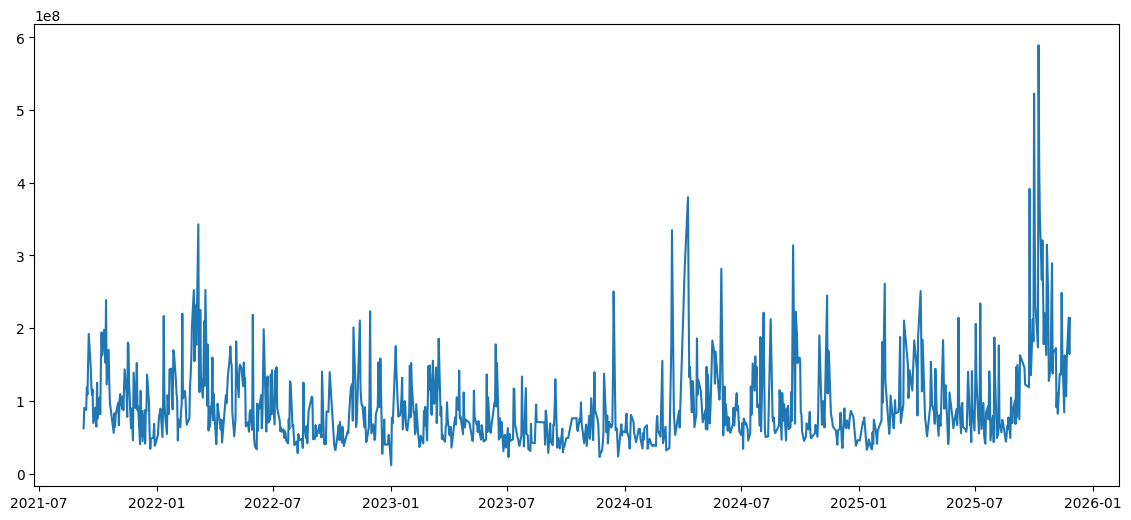

In [10]:
# check monetary difference between kgh and cla
from matplotlib import pyplot as plt
data = mock_sql_magic("select cla.date, kgh.close*kgh.volume - cla.close*cla.volume from cla join kgh on cla.date = kgh.date", return_data=True)
df = pd.DataFrame(data, columns=["date", "value_difference"])
df["date"] = pd.to_datetime(df["date"])
df = df.set_index(df["date"])
df = df.drop(columns="date")
plt.figure(figsize=(14,6))
plt.plot(df)
plt.show()

## Pandas based EDA

f:\codes\projekty\etl_finance_demo\etl_finance_demo\src\DataEDA.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs.show()


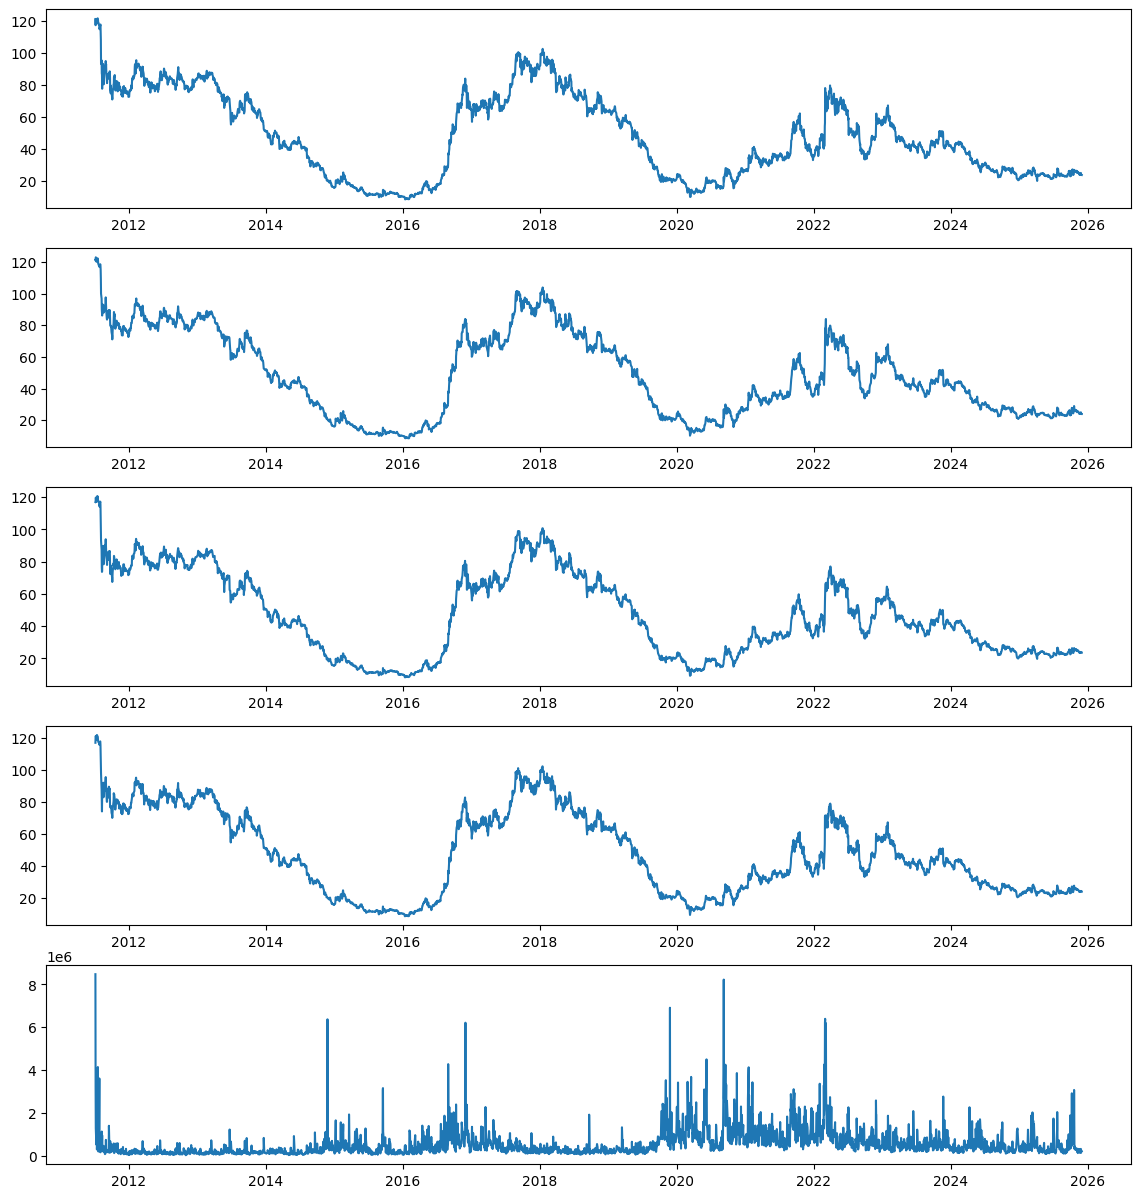

In [ ]:
from src.DataEDA import DataEDA
import sqlite3
with sqlite3.connect("SQLite.db") as conn:
    eda_jsw = DataEDA(conn, "jsw")
eda_jsw.plot_ticker()

In [17]:
df_jsw.describe()

,open,high,low,close,volume
count,3597.000000,3597.000000,3597.000000,3597.000000,3.597000e+03
mean,47.473939,48.365497,46.534129,47.422154,5.340372e+05
std,25.590578,25.931971,25.236367,25.613318,6.274407e+05
min,8.264200,8.557600,8.197900,8.302000,1.708000e+04
25%,24.400000,24.980000,23.920000,24.330000,1.757220e+05
50%,42.870000,43.792000,42.020000,42.864000,3.340230e+05
75%,69.389000,70.610000,67.836000,69.341000,6.489420e+05
max,121.470000,122.940000,120.610000,121.910000,8.471186e+06


In [18]:
df_kgh.describe()

,open,high,low,close,volume
count,7104.000000,7104.000000,7104.000000,7104.000000,7.104000e+03
mean,67.765084,68.724023,66.683067,67.685325,1.264634e+06
std,51.574384,52.277350,50.770780,51.518585,1.043334e+06
min,3.156040,3.221720,3.077380,3.125430,6.048700e+04
25%,10.064050,10.234400,9.940790,10.072400,5.809485e+05
50%,69.086450,70.240450,67.701700,69.219950,9.517920e+05
75%,108.370250,109.942000,106.936000,108.304500,1.589379e+06
max,215.643000,218.197000,206.567000,211.571000,1.387913e+07


checking stationary features

In [19]:
def add_stationary_features(df: pd.DataFrame):
    df["spread"] = df["high"] - df["low"]
    df["price_change"] = df["close"] - df["open"]
    df["circulation"] = ((df["open"] + df["close"])/2) * df["volume"]
    df["volatility_weighted_flow"] = df["spread"] * df["volume"]

In [20]:
add_stationary_features(df_jsw)
df_jsw.head()

,open,high,low,close,volume,spread,price_change,circulation,volatility_weighted_flow
date,,,,,,,,,
2011-07-06,121.05,121.39,117.00,117.17,8471186,4.39,-3.88,1.009003e+09,37188506.54
2011-07-07,117.17,120.87,117.17,120.36,3224540,3.70,3.19,3.829625e+08,11930798.00
2011-07-08,120.78,122.94,119.75,121.47,1276091,3.19,0.69,1.545665e+08,4070730.29
2011-07-11,120.87,122.25,118.11,118.89,513010,4.14,-1.98,6.149964e+07,2123861.40
2011-07-12,118.03,120.10,117.17,119.66,965478,2.93,1.63,1.147422e+08,2828850.54


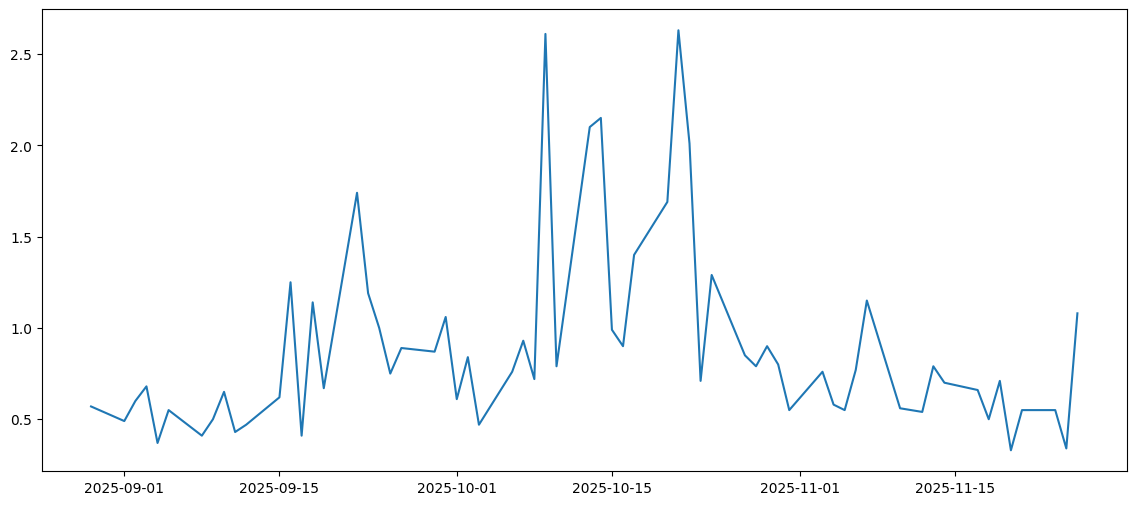

In [21]:
df_temp = df_jsw.loc[df_jsw.index > datetime.datetime.now() - datetime.timedelta(days=90)]
plt.figure(figsize=(14,6))
plt.plot(df_temp.index, df_temp["spread"])
plt.show()

20.87322768974145
4.621351125938282


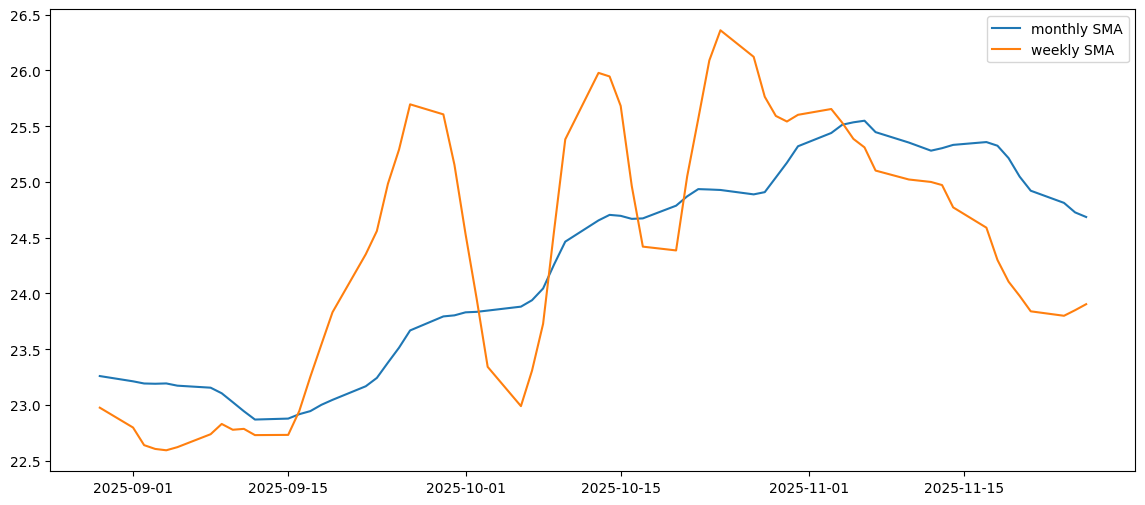

In [25]:
def add_timed_features(df):
  df["Year"] = df.index.year
  df["Month"] = df.index.month
  df["Week"] = df.index.isocalendar().week
  df["Monthly_mean_close"] = df.groupby(["Year", "Month"])["close"].transform("mean")
  print(df.groupby(["Year", "Month"])["close"].transform("count").mean()) #= 21
  print(df.groupby(["Year", "Month", "Week"])["close"].transform("count").mean()) #= 4.61
  # based on these we can set rolling metrics for week at 5 and month at 21
  trading_week_length = 5
  trading_month_length = 21
  df["Monthly_trading_days"] = df.groupby(["Year", "Month"])["close"].transform("count")
  df["SMA_weekly"] = df["close"].rolling(trading_week_length).mean()
  df["SMA_monthly"] = df["close"].rolling(trading_month_length).mean()
  df["Volatility_weekly"] = df["close"].rolling(trading_week_length).std()
  df["Volatility_monthly"] = df["close"].rolling(trading_month_length).std()
  df["Momentum_weekly"] = df["close"] - df["close"].shift(trading_week_length)
  df["Momentum_monthly"] = df["close"] - df["close"].shift(trading_month_length)
  df["EMA_weekly"] = df["close"].ewm(span = trading_week_length, adjust=False).mean()
  df["EMA_monthly"] = df["close"].ewm(span = trading_month_length, adjust=False).mean()

  df = df.drop(columns=["Year", "Month", "Week"])
  return df
df_temp = df_jsw.copy()
df_temp = add_timed_features(df_temp)
df_temp = df_temp.loc[df_temp.index > datetime.datetime.now() - datetime.timedelta(days=90)]
plt.figure(figsize=(14,6))
plt.plot(df_temp.index, df_temp["SMA_monthly"])
plt.plot(df_temp.index, df_temp["SMA_weekly"])
plt.legend(["monthly SMA", "weekly SMA"])
plt.show()